In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
import sklearn
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
import random
import warnings
from sklearn.decomposition import PCA
import Processor
import importlib

In [69]:
index_names  = ['id', 'cycles']
setting_names  = ['setting_1', 'setting_2', 'setting_3']
sensor_names = [f"s_{x}" for x in range(1, 22)]
col_names = index_names + setting_names + sensor_names

def apply_names (path, column_names):
    df  = pd.read_csv(path, header=None, delimiter =r"\s+", names = column_names)
#     df = df.set_axis(column_names, axis=1)
    return df
df_train = apply_names('train_FD001.csv', col_names)
df_test= apply_names('test_FD001.csv', col_names)

100
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         20631 non-null  int64  
 1   cycles     20631 non-null  int64  
 2   setting_1  20631 non-null  float64
 3   setting_2  20631 non-null  float64
 4   setting_3  20631 non-null  float64
 5   s_1        20631 non-null  float64
 6   s_2        20631 non-null  float64
 7   s_3        20631 non-null  float64
 8   s_4        20631 non-null  float64
 9   s_5        20631 non-null  float64
 10  s_6        20631 non-null  float64
 11  s_7        20631 non-null  float64
 12  s_8        20631 non-null  float64
 13  s_9        20631 non-null  float64
 14  s_10       20631 non-null  float64
 15  s_11       20631 non-null  float64
 16  s_12       20631 non-null  float64
 17  s_13       20631 non-null  float64
 18  s_14       20631 non-null  float64
 19  s_15       20631 non-null  float64
 20  s_

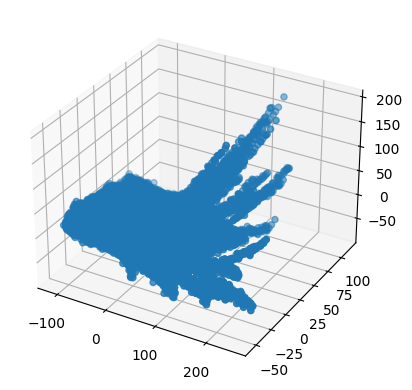

In [70]:
df_train.head()
print(len(df_train['id'].unique()))
df_train.info()
fig =plt.figure()
ax = fig.add_subplot(projection='3d')

pca = PCA(n_components=3)
fit_data = pca.fit_transform(df_train)
ax.scatter(fit_data[:,0],fit_data[:,1], fit_data[:,2])

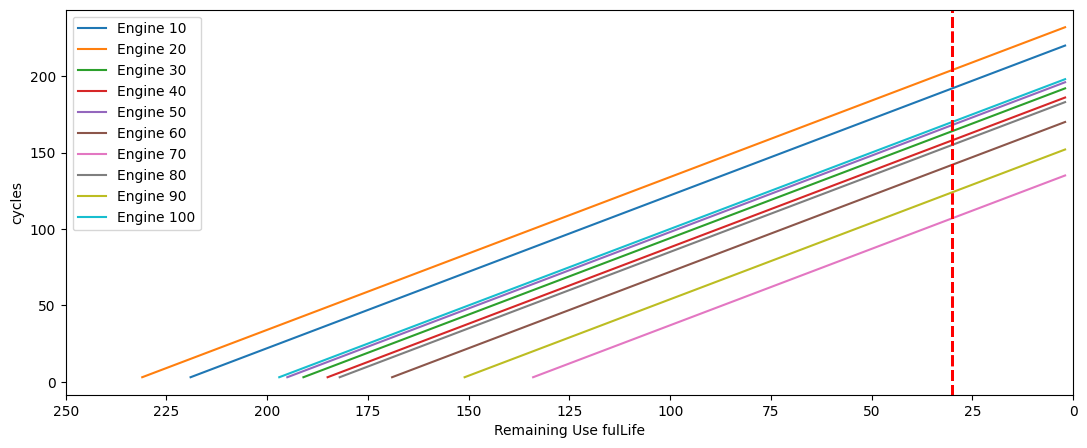

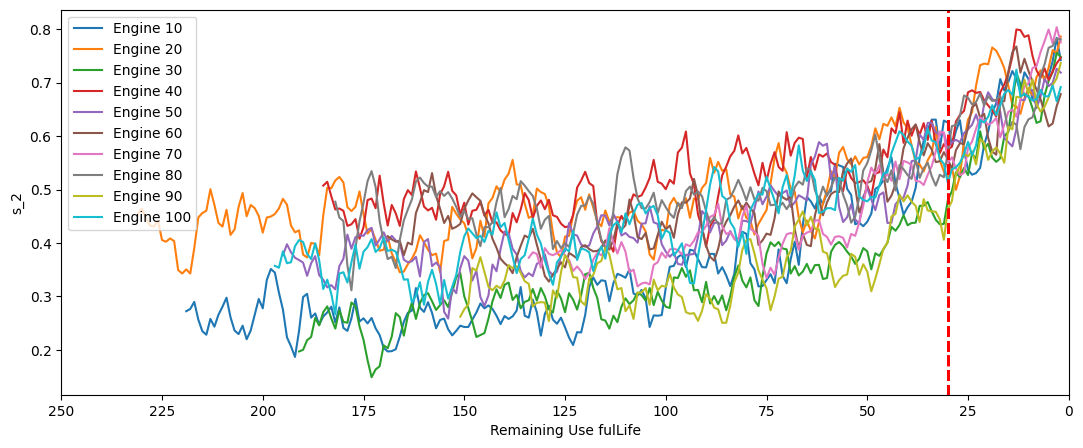

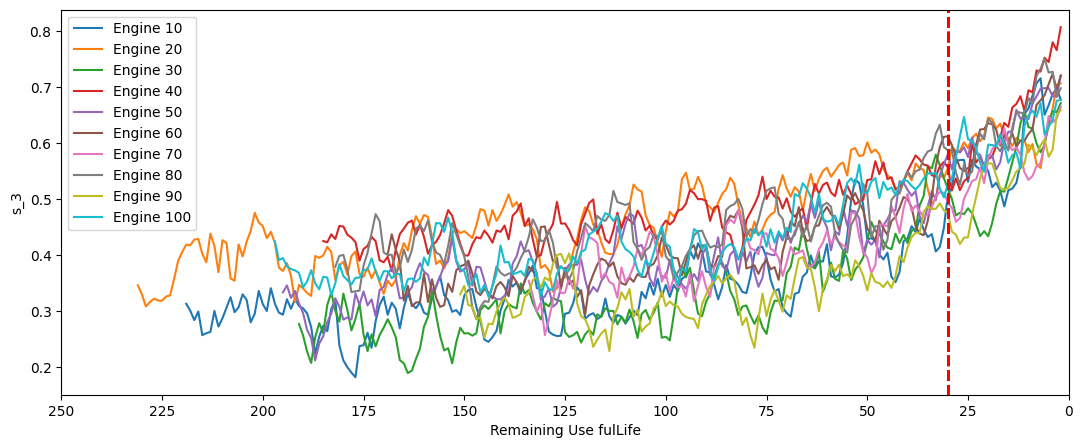

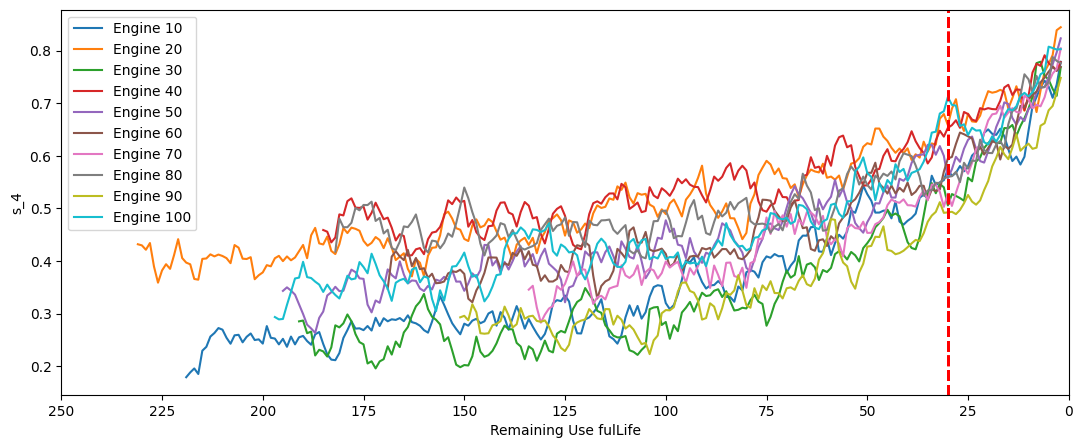

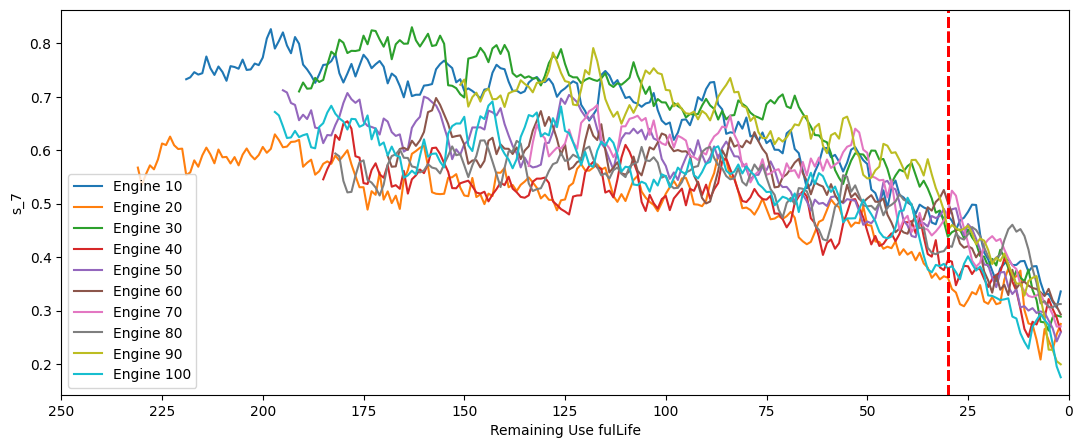

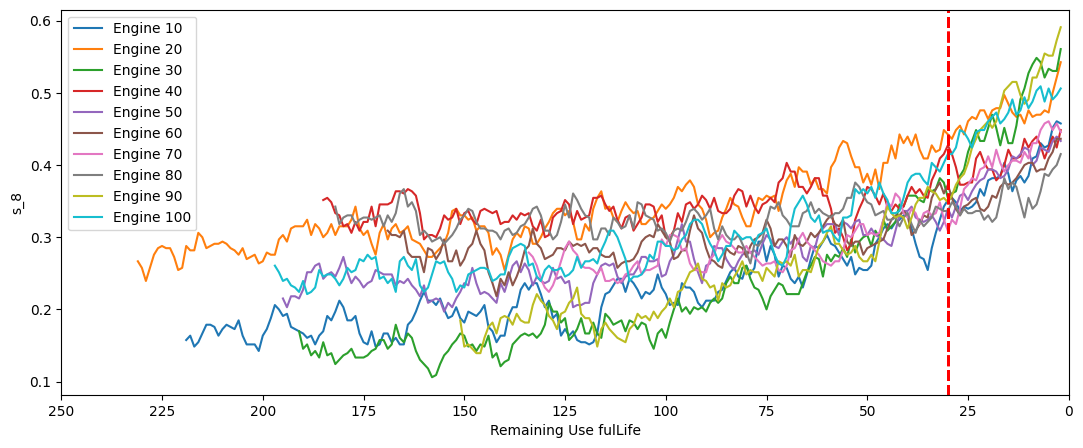

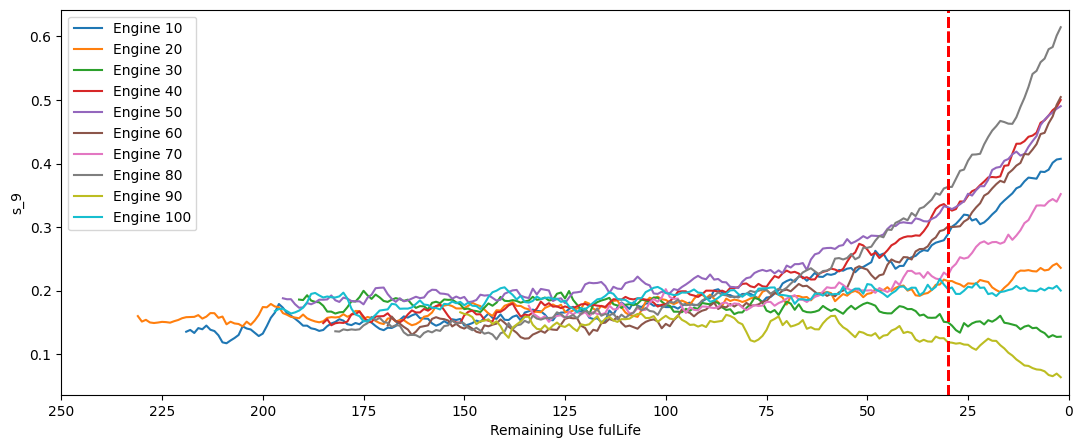

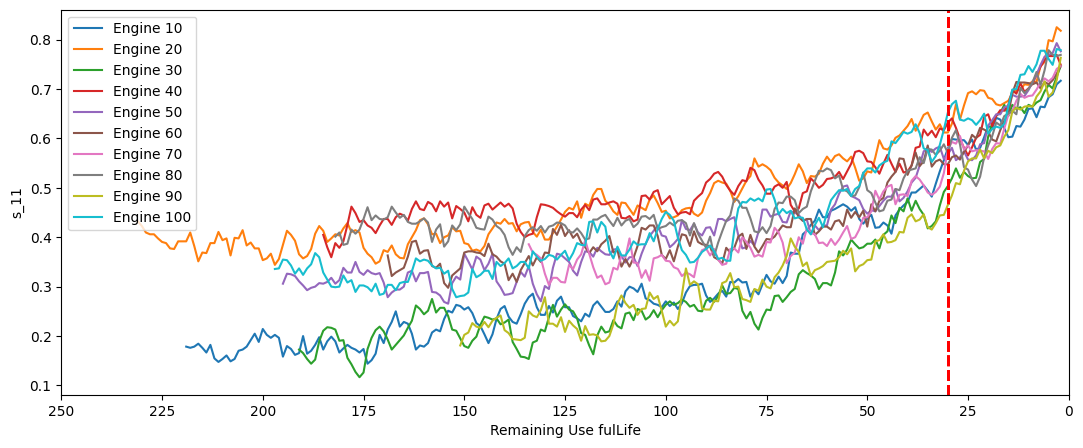

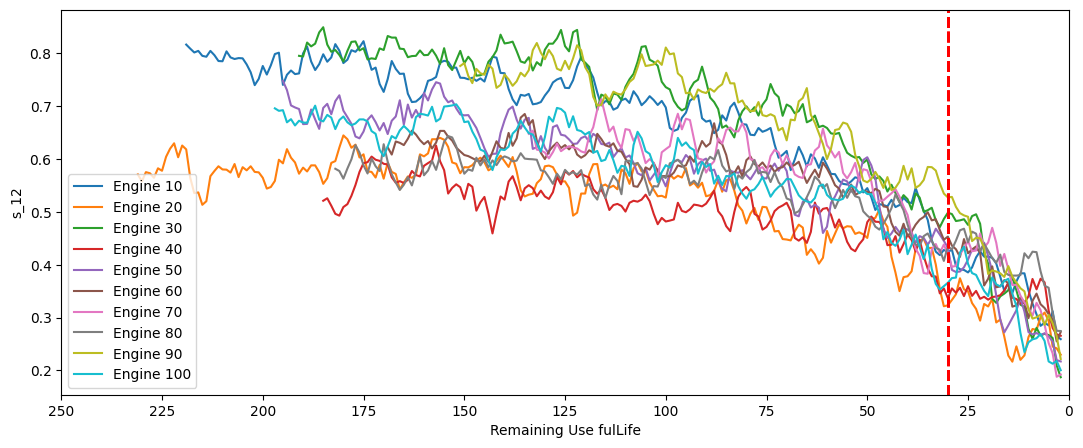

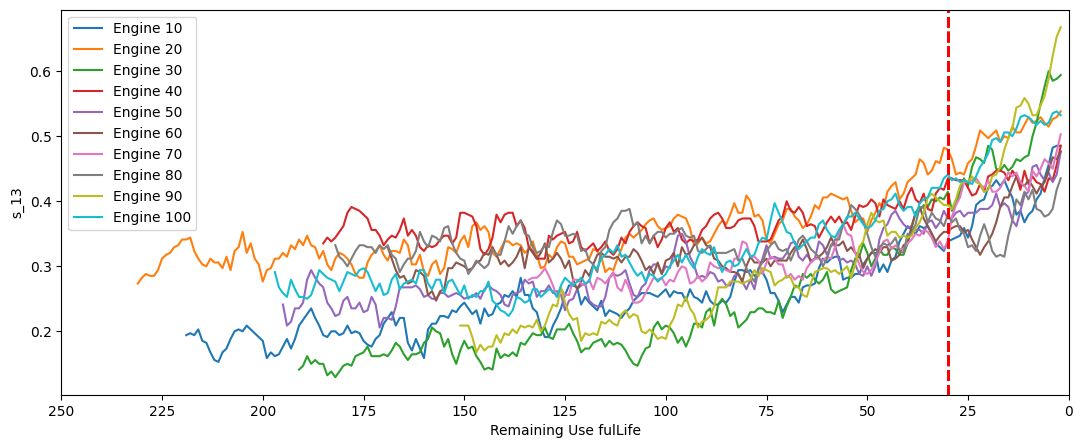

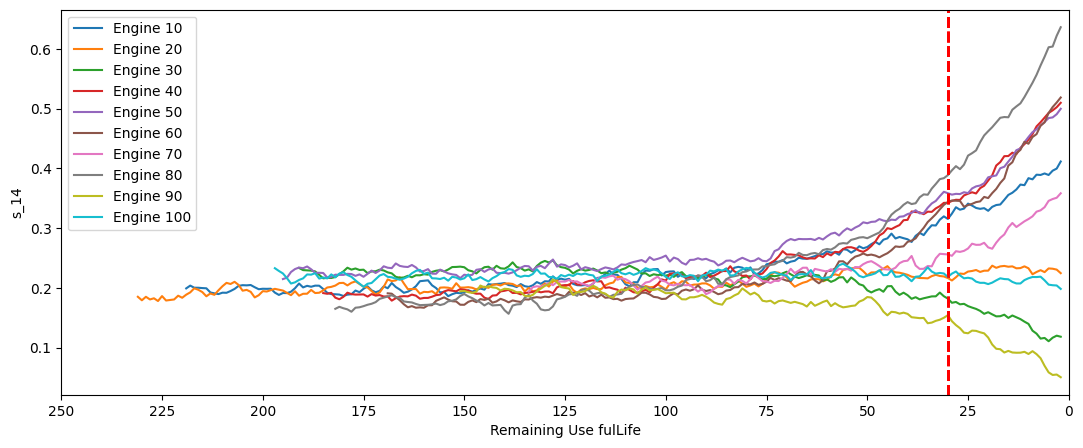

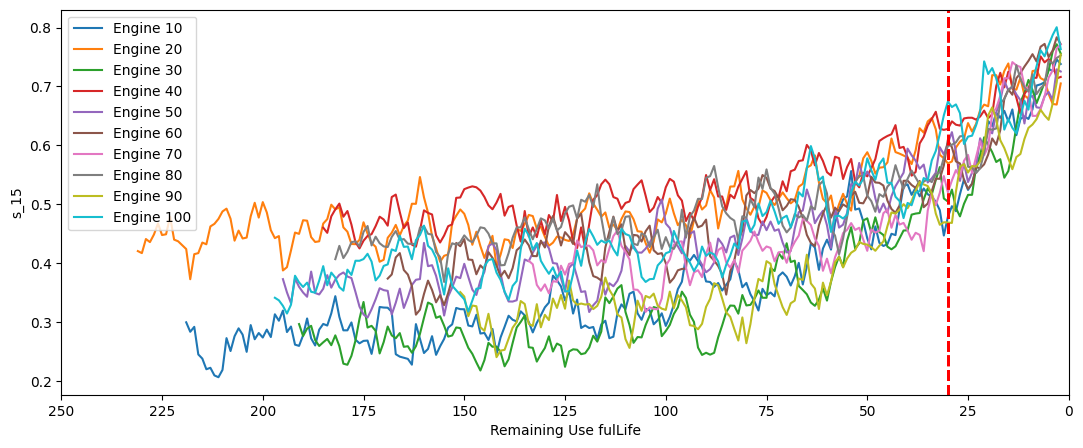

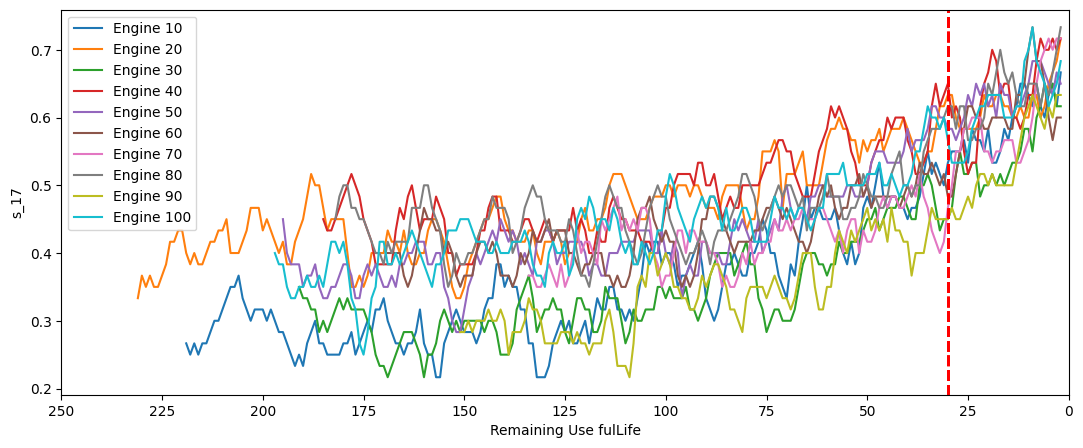

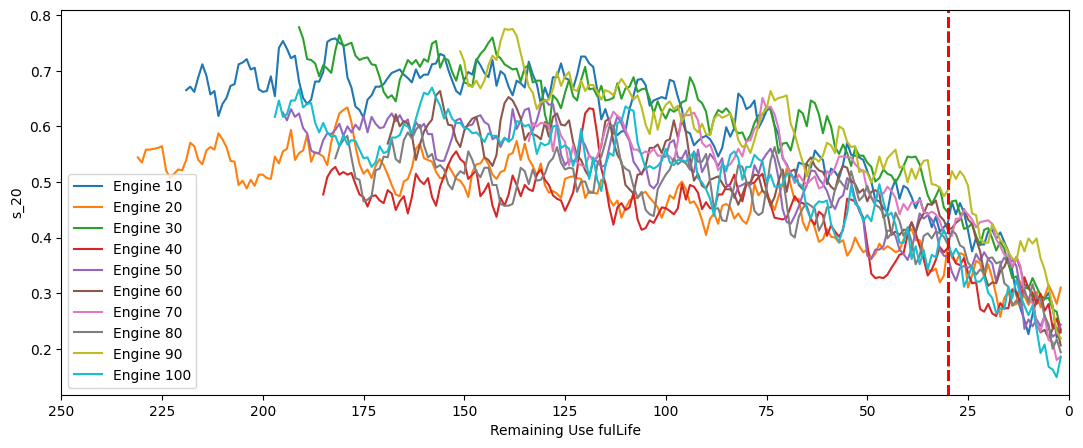

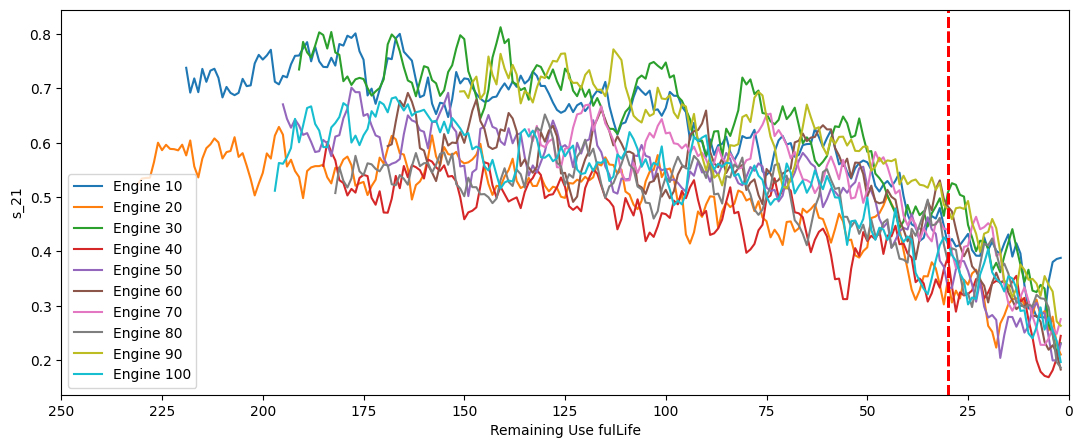

In [71]:
importlib.reload(Processor)
df_train = Processor.calculate_RUL(df_train)
df_test = Processor.calculate_RUL(df_test)

normalized_train = Processor.normalizer(df_train, sensor_names)
normalized_test = Processor.normalizer(df_test, sensor_names)

columns_to_drop = ['setting_1', 'setting_2', 'setting_3', 's_1', 's_5', 's_6', 's_10', 's_16', 's_18', 's_19']

normalized_train = Processor.drop_col(normalized_train, columns_to_drop)
normalized_test = Processor.drop_col(normalized_test, columns_to_drop)


def plot_sensor(sensor_name,X):
    plt.figure(figsize=(13,5))
    for i in X['id'].unique():
#         if i == 10:
#             continue
        if (i % 10 == 0):  # only plot every engine
            plt.plot('RUL', sensor_name, 
                     data=X[X['id']==i].rolling(5).mean(), alpha = 1, label = f'Engine {i}')
            plt.axvline(30, color='red', linestyle='dashed', linewidth=2)
    plt.rcParams['figure.facecolor'] = 'white'
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(sensor_name)
    plt.xlabel('Remaining Use fulLife')
    plt.legend()
    plt.show()
    

for sensor in normalized_train.drop(['id', 'RUL'], axis=1).columns:
    plot_sensor(sensor, normalized_train)
    

In [72]:
normalized_train.head()
print(normalized_train['id'].value_counts().min())
normalized_test.head()

128


,id,cycles,RUL,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21
0,1,1,30,0.596215,0.421968,0.282214,0.608871,0.365854,0.196475,0.273973,0.534247,0.325581,0.152259,0.347076,0.375,0.500000,0.620099
1,1,2,29,0.182965,0.504025,0.225240,0.800403,0.292683,0.229042,0.479452,0.634703,0.395349,0.277907,0.227709,0.500,0.645455,0.645718
2,1,3,28,0.419558,0.464814,0.346130,0.651210,0.390244,0.248506,0.479452,0.591324,0.325581,0.192892,0.533557,0.500,0.700000,0.681104
3,1,4,27,0.413249,0.391587,0.449867,0.643145,0.341463,0.159080,0.328767,0.456621,0.372093,0.217896,0.282359,0.250,0.627273,0.620382
4,1,5,26,0.435331,0.471306,0.357974,0.661290,0.292683,0.153410,0.349315,0.632420,0.325581,0.187891,0.337009,0.125,0.618182,0.676008


In [74]:
sensor_cols = [col for col in normalized_train.columns if 'sensor' in col or 'op_setting' in col]

def make_features(df, window_size=30):
    sensor_cols = [col for col in df.columns if col not in ['id', 'cycles', 'RUL']]
    feature_rows = []

    for engine_id, group in df.groupby('id'):
        if len(group) < window_size:
            continue  # skip engines with fewer than `window_size` cycles

        group = group.sort_values('cycles', ascending=False).head(window_size)
        row = group[sensor_cols].agg(['mean', 'std', 'min', 'max']).T
        row.columns = [f'{stat}' for stat in row.columns]
        row = row.stack().to_frame().T
        row['id'] = engine_id
        feature_rows.append(row)

    if not feature_rows:
        raise ValueError("No engines had enough data for the given window size.")

    features_df = pd.concat(feature_rows).reset_index(drop=True)
    return features_df

# X_train = normalized_train
y_train = normalized_train.groupby('id')['RUL'].min().reset_index(drop=True)

# X_train = normalized_train[sensor_names]
# y_train = normalized_train['RUL']
# X = X_train.values
X = make_features(normalized_train).drop(columns = 'id')
# print(np.shape(X))
y = y_train.values
# print(np.shape(y))

def fit_bayesian_linear_regression(X, y, alpha=1.0, beta=25.0):
    D = X.shape[1]
    I = np.eye(D)
    S_N = np.linalg.inv(alpha * I + beta * X.T @ X)
    m_N = beta * S_N @ X.T @ y
    return m_N, S_N


def fit_bayesian_linear_regression(X, y, alpha=1.0, beta=25.0):
    D = X.shape[1]
    I = np.eye(D)
    S_N = np.linalg.inv(alpha * I + beta * X.T @ X)
    m_N = beta * S_N @ X.T @ y
    return m_N, S_N

def predict_bayesian(X_new, m_N, S_N, beta=25.0):
    means = X_new @ m_N
    variances = (1 / beta) + np.sum(X_new @ S_N * X_new, axis=1)
    return means, np.sqrt(variances)
m_N, S_N = fit_bayesian_linear_regression(X, y)

# m_N, S_N = fit_bayesian_linear_regression(X_train.values, y_train.values)
X_test = make_features(normalized_test).drop(columns = 'id')
# X_test = normalized_test
# X_test.drop(columns='id', inplace=True)
y_pred_mean, y_pred_std = predict_bayesian(X_test.values, m_N, S_N)

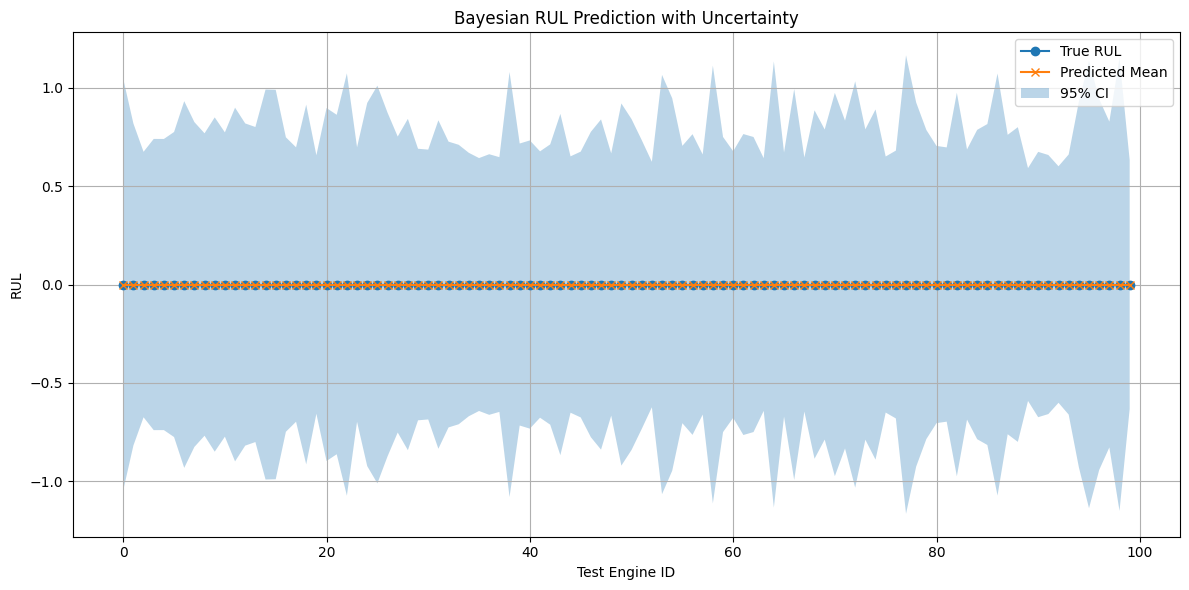

In [76]:
y_true = normalized_test.groupby('id')['RUL'].min().reset_index(drop=True)

plt.figure(figsize=(12, 6))
plt.plot(y_true, label='True RUL', marker='o')
plt.plot(y_pred_mean, label='Predicted Mean', marker='x')
plt.fill_between(np.arange(len(y_true)),
                 y_pred_mean - 1.96 * y_pred_std,
                 y_pred_mean + 1.96 * y_pred_std,
                 alpha=0.3, label='95% CI')
plt.xlabel("Test Engine ID")
plt.ylabel("RUL")
plt.legend()
plt.title("Bayesian RUL Prediction with Uncertainty")
plt.grid(True)
plt.tight_layout()
plt.show()